In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!unzip /content/gdrive/MyDrive/FPRDataset
clear_output()

In [6]:
print("Train Nodule:",len(os.listdir("/content/gdrive/MyDrive/FPRDataset/train/nodule")))
print("Train Non-Nodule:",len(os.listdir("/content/gdrive/MyDrive/FPRDataset/train/non-nodule")))
print("Test Nodule:",len(os.listdir("/content/gdrive/MyDrive/FPRDataset/test/nodule")))
print("Test Non-Nodule:",len(os.listdir("/content/gdrive/MyDrive/FPRDataset/test/non-nodule")))

Train Nodule: 70
Train Non-Nodule: 1832
Test Nodule: 33
Test Non-Nodule: 500


In [7]:
BATCH_SIZE = 96
generator = ImageDataGenerator(rescale=1./255)
trainData = generator.flow_from_directory(
    "/content/gdrive/MyDrive/FPRDataset/train",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)
testData = generator.flow_from_directory(
    "/content/gdrive/MyDrive/FPRDataset/test",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

Found 1902 images belonging to 2 classes.
Found 533 images belonging to 2 classes.


In [8]:
print(trainData.class_indices)
print(testData.class_indices)

{'nodule': 0, 'non-nodule': 1}
{'nodule': 0, 'non-nodule': 1}


In [9]:
weight_path="checkpoint-{epoch:03d}-{val_loss:.3f}.hdf5"
modelcheckpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import AveragePooling2D


In [11]:
def dense_block(x, growth_rate, filters):
    """
    Defines a Dense Block for the DenseNet architecture.

    Args:
        x: Input tensor.
        growth_rate: Number of filters to add per layer within the block.
        filters: Number of filters in the current layer.

    Returns:
        Output tensor of the Dense Block.
    """

    for _ in range(4):
        out = tf.keras.layers.BatchNormalization()(x)
        out = tf.keras.layers.ReLU()(out)
        out = tf.keras.layers.Conv2D(growth_rate, (3, 3), padding="same")(out)
        filters += growth_rate
        x = tf.keras.layers.concatenate([x, out])
    return x, filters


In [12]:
def transition_layer(x, filters):
    """
    Defines a Transition Layer for downsampling the feature maps.

    Args:
        x: Input tensor.
        filters: Number of filters in the current layer.

    Returns:
        Output tensor of the Transition Layer.
    """

    out = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv2D(filters, (1, 1), use_bias=False)(out)
    out = tf.keras.layers.AveragePooling2D((2, 2), strides=2)(out)
    return out


In [13]:
def build_model(input_shape=(50, 50, 1), num_classes=1):
    """
    Builds the DenseNet architecture for lung nodule detection.

    Args:
        input_shape: Shape of the input images.
        num_classes: Number of output classes.

    Returns:
        A compiled Keras model.
    """

    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding="same")(inputs)

    # Dense blocks and transition layers
    filters = 64
    x, filters = dense_block(x, 32, filters)
    x = transition_layer(x, filters // 2)

    x, filters = dense_block(x, 32, filters)
    x = transition_layer(x, filters // 2)

    # Global average pooling and output layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Example usage
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 50, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 25, 25, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 25, 25, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 25, 25, 64)           0         ['batch_normalization[0][0

In [15]:
with tf.device("/device:GPU:0"):
  history = model.fit_generator(
      trainData,
      epochs=100,
      validation_data=testData,
      verbose=1,
      callbacks=[modelcheckpoint]
  )


<ipython-input-15-fb71fba0ae00>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9942
Epoch 1: val_loss did not improve from 0.05616
20/20 [==============================] - 5s 259ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 0.7861 - val_accuracy: 0.9644
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9958
Epoch 2: val_loss did not improve from 0.05616
20/20 [==============================] - 4s 213ms/step - loss: 0.0094 - accuracy: 0.9958 - val_loss: 0.6177 - val_accuracy: 0.9531
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9942
Epoch 3: val_loss did not improve from 0.05616
20/20 [==============================] - 4s 197ms/step - loss: 0.0142 - accuracy: 0.9942 - val_loss: 0.4163 - val_accuracy: 0.9644
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9911
Epoch 4: val_loss did not improve from 0.05616
20/20 [==============================] 

Final Accuracy: 1.0


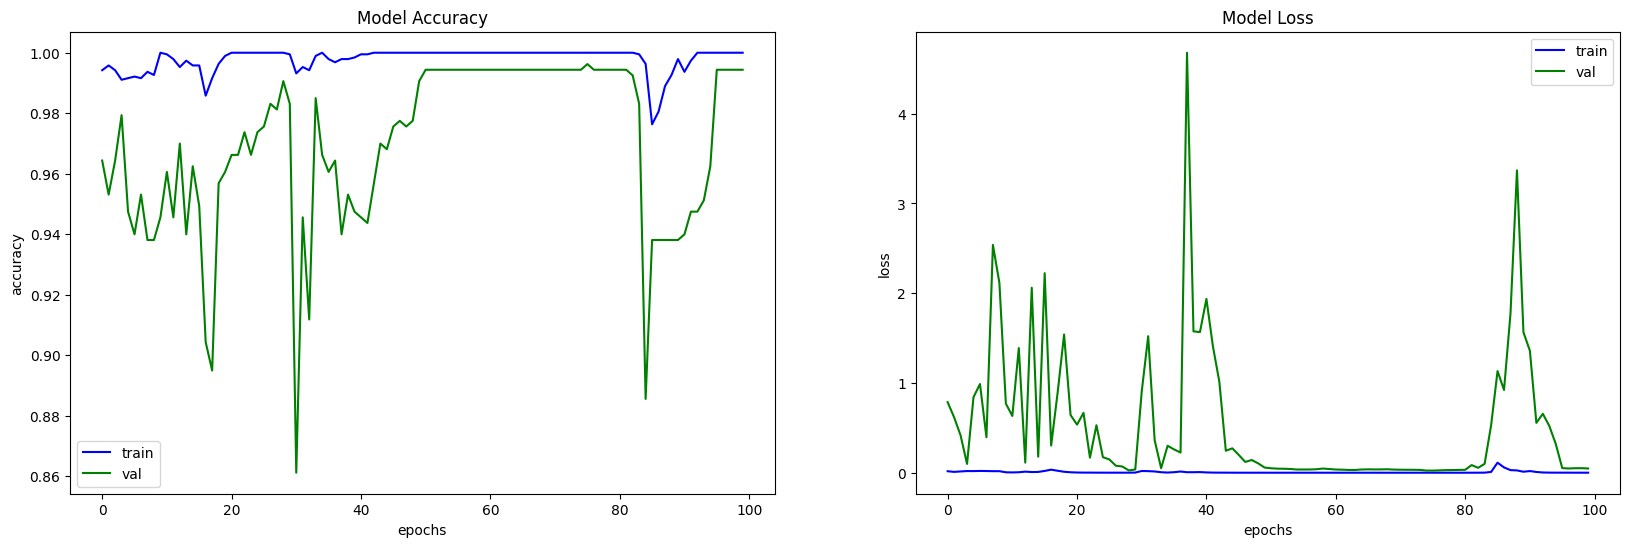

In [16]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['accuracy', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

final_accuracy = history.history['accuracy'][-1]
print("Final Accuracy:", final_accuracy)
plt.show()

In [ ]:
model.save("/content/gdrive/MyDrive/Training_logs/model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model2 = build_model()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.load_weights("/content/checkpoint-071-0.028.hdf5")
model2.save("checkpoint_model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!cp checkpoint_model2.h5 /content/gdrive/MyDrive/Training_logs/best_checkpoint_model2.h5